# Basic Tutorial: `GaussLineNoise`

Trey V. Wenger (c) July 2024

This notebook is nearly identical to the basic tutorial, except we implement a new model called `GaussLineNoise`. This model allows the spectral rms to be an inferred parameter. Such is a useful trick for complicated posterior distributions, such as when there are multiple, high signal-to-noise components.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.2.2


## Data Format

We wish to generate some synthetic data from our model, which requires us to take a brief aside to introduce the `bayes_spec` data format. We use the `SpecData` class to pass data into `bayes_spec`.

In [2]:
from bayes_spec import SpecData

# spectral axis definition
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

# Our model only expects a single observation named "observation"
# Note that because we "named" the spectrum "observation" here,
# we must use the same name in the model definition above
observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

## Simulating Data

Now that we have a model definition and a dummy data format, we can generate simulated observations by drawing samples from the parameter prior distributions.

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

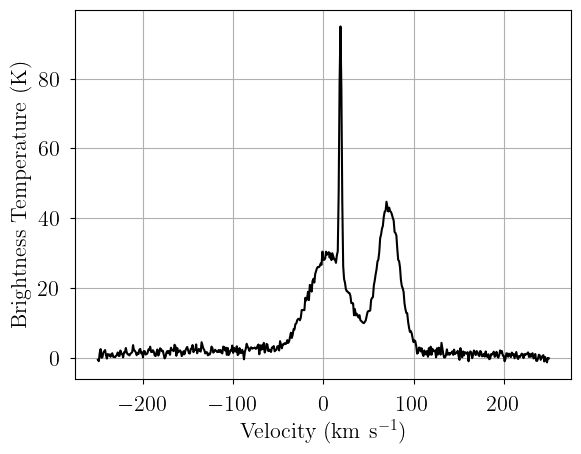

In [3]:
from bayes_spec.models import GaussLineNoise

# Initialize and define the model
model = GaussLineNoise(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0).data

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Alternatively, we can pass the relevant parameters directly to the likelihood variable, named `observation` in our model, to evaluate a model with specific model parameters. Be sure that the simulated values are reasonable given your prior distributions!

Text(0, 0.5, 'Brightness Temperature (K)')

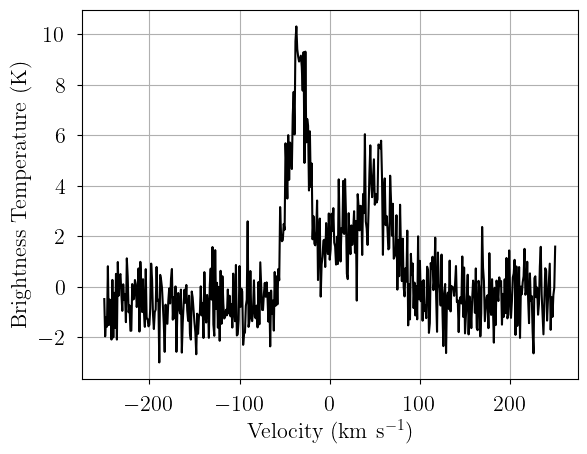

In [4]:
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "rms_observation": 1.0, # spectral rms (K)
    "observation_baseline_norm": [-0.5, 0.2, 0.05], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [5]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## Model

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `bayes_spec`.

We begin with a three-cloud (`n_cloud=3`) model, with a 2nd order polynomial baseline (`baseline_degree=2`).

In [6]:
model = GaussLineNoise(data, n_clouds=3, baseline_degree=2, seed=123456, verbose=True)
model.define(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeff = 1.0, # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)

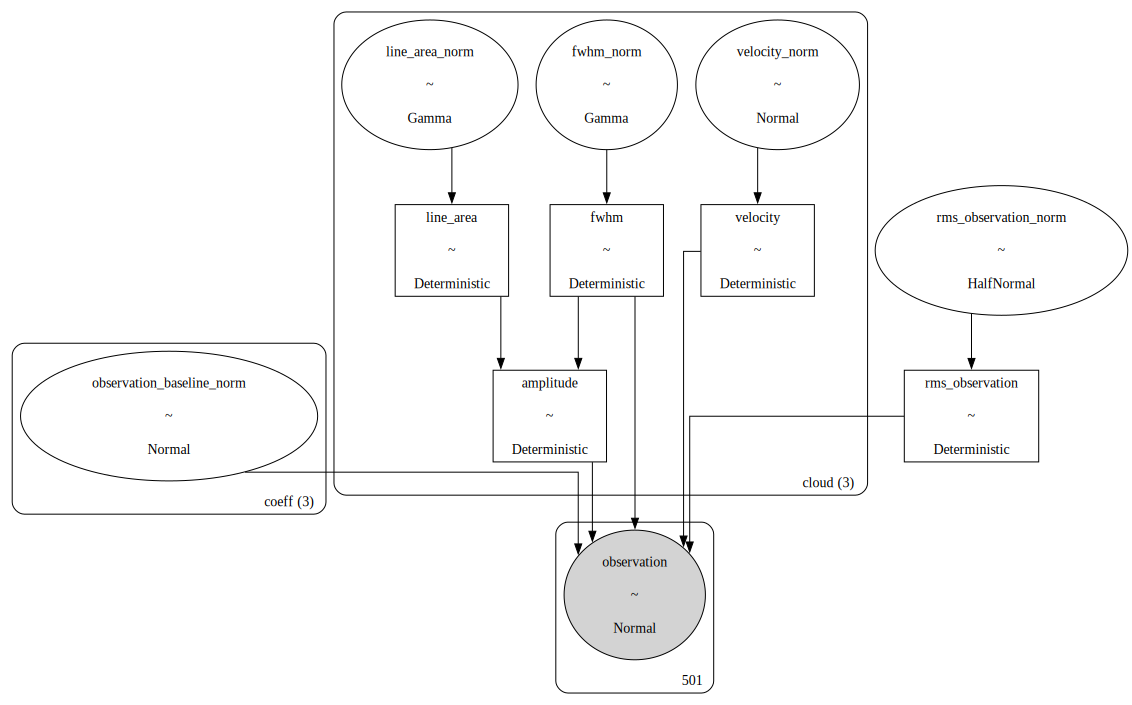

In [7]:
# Plot model graph
model.plot_graph(f"{figdir}/model_noise.gv", "svg")
SVG(f"{figdir}/model_noise.gv.{ext}")

In [8]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, 1)
           line_area_norm ~ Gamma(2, f())
                fwhm_norm ~ Gamma(2, f())
            velocity_norm ~ Normal(0, 1)
     rms_observation_norm ~ HalfNormal(0, 1)
                line_area ~ Deterministic(f(line_area_norm))
                     fwhm ~ Deterministic(f(fwhm_norm))
                 velocity ~ Deterministic(f(velocity_norm))
                amplitude ~ Deterministic(f(fwhm_norm, line_area_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              observation ~ Normal(f(fwhm_norm, line_area_norm, observation_baseline_norm, velocity_norm), rms_observation)


We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [fwhm_norm, line_area_norm, observation, observation_baseline_norm, rms_observation_norm, velocity_norm]


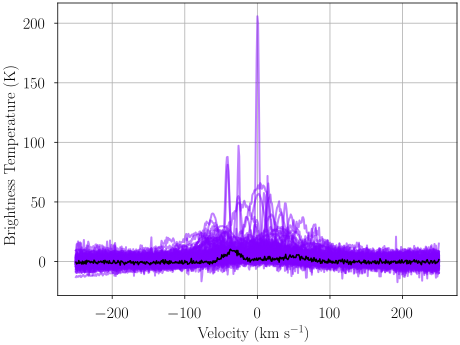

In [9]:
# prior predictive check
prior = model.prior_predictive_check(
    samples=100,  # prior predictive samples
    plot_fname=f"{figdir}/prior_predictive_noise.{ext}",
)
SVG(f"{figdir}/prior_predictive_noise.{ext}")

We can also generate a pair plot to inspect the prior distributions and their effect on deterministic quantities. The model has attributes `cloud_params` for cloud free parameters, `deterministics` for deterministic quantities, `baseline_params` for the free polynomial baseline parameters, and `hyper_params` for the hyperparameters. Here we show the pair plot for the deterministic quantities derived from our prior distributions.

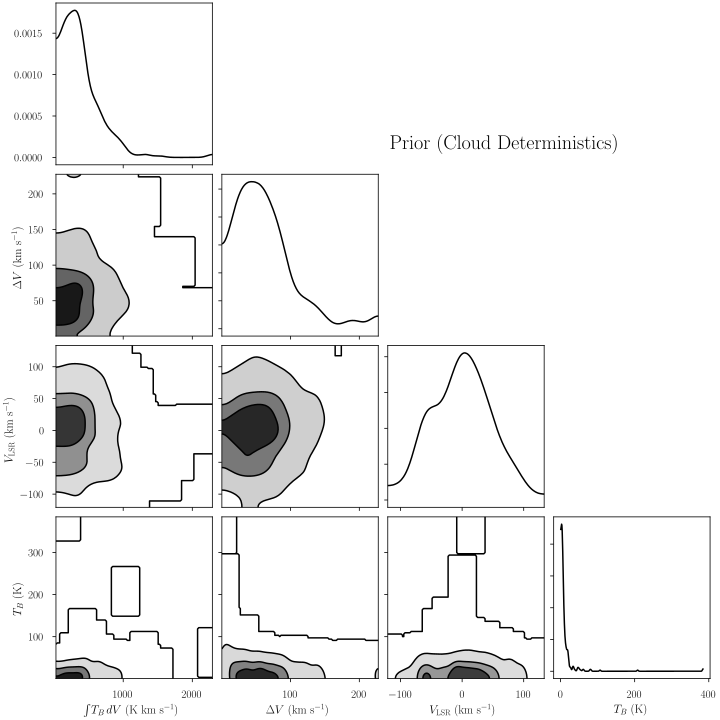

In [10]:
from bayes_spec.plots import plot_pair

# exclude rms_observation
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    "Prior (Cloud Deterministics)", # plot label
    f"{figdir}/pair_prior_determ_noise.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_prior_determ_noise.{ext}")

## Posterior Sampling: Variational Inference

We can approximate the posterior distribution using variational inference (VI). We will run a maximum of `n` iterations, but stop early if it appears that VI has converged on a solution. You will have to tune the convergence thresholds and learning rate for your model.

In [11]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,078.3


In [12]:
# posterior samples stored in model.trace.posterior
az.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.853   0.432    8.048    9.674      0.014   
amplitude[1]                    3.651   0.340    3.038    4.296      0.010   
amplitude[2]                    2.388   0.252    1.932    2.859      0.010   
fwhm[0]                        23.694   0.862   22.002   25.209      0.028   
fwhm[1]                        37.837   2.706   33.014   42.862      0.081   
fwhm[2]                        77.694   6.422   65.542   89.592      0.219   
fwhm_norm[0]                    0.790   0.029    0.733    0.840      0.001   
fwhm_norm[1]                    1.261   0.090    1.100    1.429      0.003   
fwhm_norm[2]                    2.590   0.214    2.185    2.986      0.007   
line_area[0]                  222.983   7.098  209.779  235.674      0.229   
line_area[1]                  146.306   8.581  131.545  162.895      0.278   
line_area[2]                  196.222  13.497  170.994  221.442      0.429   
line_area_norm[0]               1.115   0.035    1.049    1.178      0.001   
line_area_norm[1]               0.732   0.043    0.658    0.814      0.001   
line_area_norm[2]               0.981   0.067    0.855    1.107      0.002   
observation_baseline_norm[0]   -0.522   0.023   -0.562   -0.477      0.001   
observation_baseline_norm[1]    0.102   0.038    0.031    0.167      0.001   
observation_baseline_norm[2]    0.075   0.050   -0.016    0.165      0.002   
rms_observation                 1.038   0.038    0.967    1.107      0.001   
rms_observation_norm            0.519   0.019    0.484    0.553      0.001   
velocity[0]                   -34.660   0.492  -35.512  -33.695      0.015   
velocity[1]                    54.262   1.632   51.348   57.398      0.053   
velocity[2]                    11.877   3.564    5.475   18.935      0.108   
velocity_norm[0]               -0.693   0.010   -0.710   -0.674      0.000   
velocity_norm[1]                1.085   0.033    1.027    1.148      0.001   
velocity_norm[2]                0.238   0.071    0.109    0.379      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.010     999.0     751.0    NaN  
amplitude[1]                    0.007    1076.0    1070.0    NaN  
amplitude[2]                    0.007     717.0     909.0    NaN  
fwhm[0]                         0.020     959.0     834.0    NaN  
fwhm[1]                         0.057    1125.0     873.0    NaN  
fwhm[2]                         0.157     895.0     842.0    NaN  
fwhm_norm[0]                    0.001     959.0     834.0    NaN  
fwhm_norm[1]                    0.002    1125.0     873.0    NaN  
fwhm_norm[2]                    0.005     895.0     842.0    NaN  
line_area[0]                    0.162     961.0     945.0    NaN  
line_area[1]                    0.197     958.0     841.0    NaN  
line_area[2]                    0.303     990.0     984.0    NaN  
line_area_norm[0]               0.001     961.0     945.0    NaN  
line_area_norm[1]               0.001     958.0     841.0    NaN  
line_area_norm[2]               0.002     990.0     984.0    NaN  
observation_baseline_norm[0]    0.001     760.0     983.0    NaN  
observation_baseline_norm[1]    0.001     879.0     792.0    NaN  
observation_baseline_norm[2]    0.001     955.0     942.0    NaN  
rms_observation                 0.001     843.0     916.0    NaN  
rms_observation_norm            0.000     843.0     916.0    NaN  
velocity[0]                     0.011    1079.0     972.0    NaN  
velocity[1]                     0.037     960.0     890.0    NaN  
velocity[2]                     0.076    1092.0    1038.0    NaN  
velocity_norm[0]                0.000    1079.0     972.0    NaN  
velocity_norm[1]                0.001     960.0     890.0    NaN  
velocity_norm[2]                0.002    1092.0    1038.0    NaN

It's good practice to verify the integrity of your solution! Here we generate posterior predictive checks -- realizations of the model drawn with parameters drawn from the posterior distribution. Each line is one posterior sample.

Sampling: [observation]


Output()

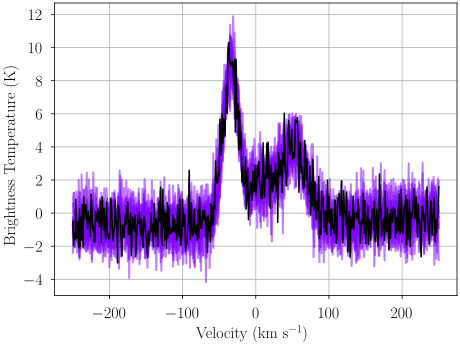

In [13]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_vi_noise.{ext}"
)
SVG(f"{figdir}/posterior_predictive_vi_noise.{ext}")

## Posterior Sampling: MCMC

VI is fast, but it's not particularly accurate, and there is no way to diagnose "convergence". Instead, we sample the posterior distribution using MCMC. Here we initialize the No U-Turn Sampler (NUTS) using VI (also available is the `pymc` default: `init="jitter+adapt_diag"`, which may be better suited to some models). We can customize the VI initialization as well as the NUTS parameters. If there are many divergences, or if the resulting effective sample sizes are small and `r_hat` is large, try increasing the number of tuning samples, draws, and/or chains. Increasing `target_accept` to `0.9` or `0.95` can help if there are many divergences. Use as many chains as possible.

In [14]:
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [0%]: Average Loss = 1,078.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


There were 2 divergences in converged chains.


If a chain does not converge, an error is printed and that chain is dropped from all subsequent analyses. In the remaining chains, there may be some divergences. The number of divergences should be much less than the number of posterior samples.

In general, there could be a labeling degeneracy, or multiple unique solutions. Here we "solve" for those effects using a Gaussian Mixture Model (GMM). The parameter `p_threshold` defines the probability threshold for "unique" GMM solutions.

In [15]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [16]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
amplitude[0]                    8.984   0.489    8.112    9.908      0.023   
amplitude[1]                    3.441   0.881    2.220    4.967      0.055   
amplitude[2]                    2.708   0.324    2.066    3.286      0.010   
fwhm[0]                        24.526   1.416   21.651   26.959      0.060   
fwhm[1]                        34.056   7.390   21.769   47.947      0.392   
fwhm[2]                        75.519  28.915   25.181  115.108      1.889   
fwhm_norm[0]                    0.818   0.047    0.722    0.899      0.002   
fwhm_norm[1]                    1.135   0.246    0.726    1.598      0.013   
fwhm_norm[2]                    2.517   0.964    0.839    3.837      0.063   
line_area[0]                  234.803  21.558  198.222  274.451      1.180   
line_area[1]                  129.744  56.628   49.661  227.977      3.577   
line_area[2]                  220.823  94.082   60.624  353.803      6.019   
line_area_norm[0]               1.174   0.108    0.991    1.372      0.006   
line_area_norm[1]               0.649   0.283    0.248    1.140      0.018   
line_area_norm[2]               1.104   0.470    0.303    1.769      0.030   
observation_baseline_norm[0]   -0.549   0.068   -0.685   -0.431      0.002   
observation_baseline_norm[1]    0.102   0.037    0.033    0.171      0.001   
observation_baseline_norm[2]    0.122   0.111   -0.096    0.319      0.004   
rms_observation                 1.031   0.034    0.969    1.095      0.001   
rms_observation_norm            0.515   0.017    0.484    0.547      0.000   
velocity[0]                   -34.791   0.483  -35.655  -33.835      0.018   
velocity[1]                    53.857   2.032   49.914   57.642      0.076   
velocity[2]                    17.316   9.164    2.330   32.342      0.484   
velocity_norm[0]               -0.696   0.010   -0.713   -0.677      0.000   
velocity_norm[1]                1.077   0.041    0.998    1.153      0.002   
velocity_norm[2]                0.346   0.183    0.047    0.647      0.010   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
amplitude[0]                    0.017     454.0    1310.0   1.01  
amplitude[1]                    0.039     320.0    1382.0   1.01  
amplitude[2]                    0.007     983.0    1958.0   1.00  
fwhm[0]                         0.042     574.0    1807.0   1.01  
fwhm[1]                         0.280     380.0    1388.0   1.01  
fwhm[2]                         1.337     279.0    1111.0   1.02  
fwhm_norm[0]                    0.001     574.0    1807.0   1.01  
fwhm_norm[1]                    0.009     380.0    1388.0   1.01  
fwhm_norm[2]                    0.045     279.0    1111.0   1.02  
line_area[0]                    0.847     360.0    1185.0   1.01  
line_area[1]                    2.564     314.0    1060.0   1.01  
line_area[2]                    4.261     281.0    1062.0   1.02  
line_area_norm[0]               0.004     360.0    1185.0   1.01  
line_area_norm[1]               0.013     314.0    1060.0   1.01  
line_area_norm[2]               0.021     281.0    1062.0   1.02  
observation_baseline_norm[0]    0.002     794.0    1317.0   1.00  
observation_baseline_norm[1]    0.001    2614.0    2423.0   1.00  
observation_baseline_norm[2]    0.003     908.0    1396.0   1.00  
rms_observation                 0.000    3251.0    2468.0   1.00  
rms_observation_norm            0.000    3251.0    2468.0   1.00  
velocity[0]                     0.013     764.0    1283.0   1.01  
velocity[1]                     0.054     750.0    1211.0   1.01  
velocity[2]                     0.342     414.0    2073.0   1.01  
velocity_norm[0]                0.000     764.0    1283.0   1.01  
velocity_norm[1]                0.001     750.0    1211.0   1.01  
velocity_norm[2]                0.007     414.0    2073.0   1.01

We again generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color, and the "thin" lines are the contributions of individual clouds. Each line is one posterior sample.

Sampling: [observation]


Output()

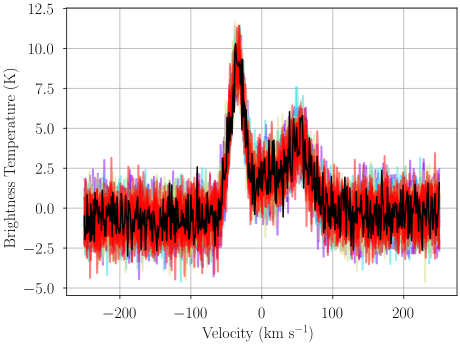

In [17]:
posterior_predictive = model.posterior_predictive_check(
    thin=100, plot_fname=f"{figdir}/posterior_predictive_noise.{ext}"
)
SVG(f"{figdir}/posterior_predictive_noise.{ext}")

In [18]:
model.plot_traces(f"{figdir}/traces_noise.{ext}")
SVG(f"{figdir}/traces_noise.{ext}")

We can inspect the posterior distribution pair plots. First, the (deterministic) cloud parameters.

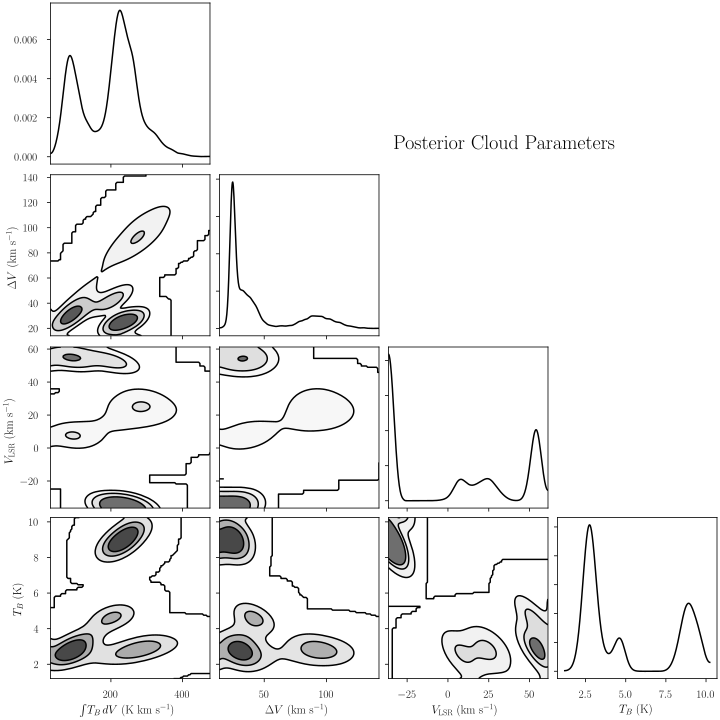

In [19]:
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_noise.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_noise.{ext}")

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions for a single cloud.

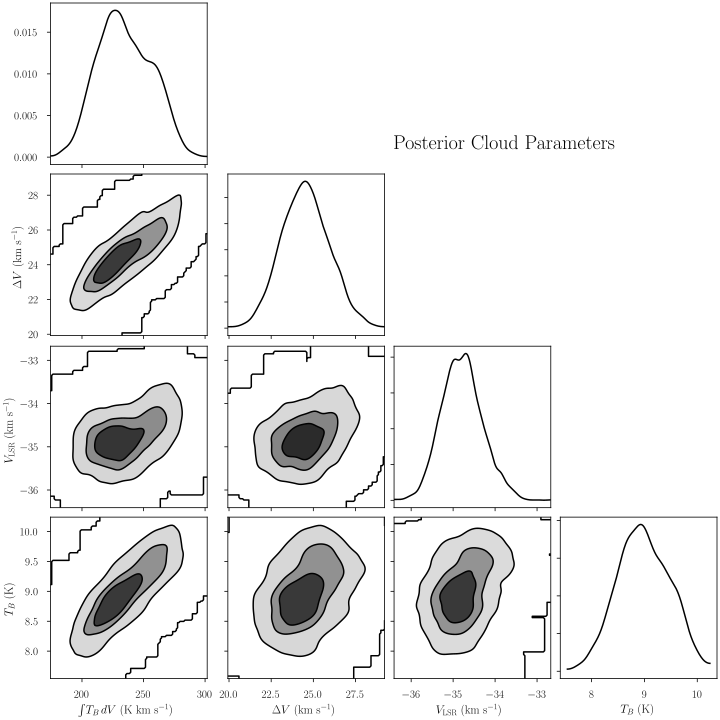

In [20]:
var_names = [var_name for var_name in model.deterministics if var_name != "rms_observation"]
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    "Posterior Cloud Parameters", # plot label
    f"{figdir}/pair_posterior_cloud_params_0_noise.{ext}", # plot filename
    labeller=model.labeller, # label manager
)
SVG(f"{figdir}/pair_posterior_cloud_params_0_noise.{ext}")

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 1556.1131309170673


mean      sd  hdi_16%  hdi_84%
line_area[0]     234.803  21.558  210.745  256.844
line_area[1]     129.744  56.628   56.193  172.668
line_area[2]     220.823  94.082   79.711  293.606
fwhm[0]           24.526   1.416   23.022   25.846
fwhm[1]           34.056   7.390   24.890   40.166
fwhm[2]           75.519  28.915   55.357  119.287
velocity[0]      -34.791   0.483  -35.272  -34.320
velocity[1]       53.857   2.032   52.005   55.926
velocity[2]       17.316   9.164    5.868   25.784
amplitude[0]       8.984   0.489    8.476    9.491
amplitude[1]       3.441   0.881    2.241    4.218
amplitude[2]       2.708   0.324    2.412    3.047
rms_observation    1.031   0.034    0.995    1.062